# Deep KNN method

This notebook aims at evaluating the **DKNN method**.

The method consists in performing K-Nearest-Neighbors in the feature space of a neural
network trained on the in-distribution dataset.

Here, we focus on a toy convolutional network trained on MNIST[0-4] and a ResNet model
trained on CIFAR-10, respectively challenged on MNIST[5-9] and SVHN OOD datasets.

**Reference**
[Out-of-Distribution Detection with Deep Nearest Neighbors](http://arxiv.org/abs/2204.06507),
ICML 2022.


### Imports


In [1]:
%load_ext autoreload
%autoreload 2

import os

os.environ["KERAS_BACKEND"] = "tensorflow"
# os.environ["KERAS_BACKEND"] = "torch"

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

from IPython.display import clear_output
import numpy as np
import keras
import matplotlib.pyplot as plt

from oodeel.methods import DKNN, Mahalanobis, SHE
from oodeel.eval.metrics import bench_metrics
from oodeel.eval.plots import plot_ood_scores, plot_roc_curve, plot_2D_features
from oodeel.datasets import load_data_handler

if keras.config.backend() == "torch":
    keras.config.set_image_data_format("channels_first")

2025-04-16 11:19:35.803073: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744795175.814636 4186910 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744795175.818206 4186910 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744795175.827843 4186910 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744795175.827852 4186910 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744795175.827853 4186910 computation_placer.cc:177] computation placer alr

Note that models are saved at _~/.oodeel/saved_models_ and data is supposed to be found
at _~/.oodeel/datasets_ by default. Change the following cell for a custom path.


In [2]:
model_path = os.path.expanduser("~/") + ".oodeel/saved_models"
data_path = os.path.expanduser("~/") + ".oodeel/datasets"
os.makedirs(model_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)

## First experiment: MNIST[0-4] vs MNIST[5-9]

For this first experiment, we train a toy convolutional network on the MNIST dataset
restricted to digits 0 to 4. After fitting the train subset of this dataset to the DKNN
method, we will compare the scores returned for MNIST[0-4] (in-distribution) and
MNIST[5-9] (out-of-distribution) test subsets.


### Data loading

- In-distribution data: MNIST[0-4]
- Out-of-distribution data: MNIST[5-9]

> **Note:** We denote In-Distribution (ID) data with `_in` and Out-Of-Distribution (OOD)
> data with `_out` to avoid confusion with OOD detection which is the name of the task,
> and is therefore used to denote the core class
> `OODBaseDetector`.



In [3]:
# === Load ID and OOD data ===
batch_size = 128
in_labels = [0, 1, 2, 3, 4]


# 1- Load train/test MNIST dataset
data_handler = load_data_handler("keras3")


if keras.config.backend() == "tensorflow":

    # 1- Load train/test MNIST dataset
    ds_train = data_handler.load_dataset("mnist", load_kwargs=dict(split="train"))
    ds_test = data_handler.load_dataset("mnist", load_kwargs=dict(split="test"))

    # 2- Split ID / OOD data depending on label value:
    # in-distribution: MNIST[0-4] / out-of-distribution: MNIST[5-9]
    ds_train, _ = data_handler.split_by_class(ds_train, in_labels)
    ds_in, ds_out = data_handler.split_by_class(ds_test, in_labels)

    # 3- Prepare data (preprocess, shuffle, batch)
    def preprocess_fn(inputs):
        inputs["image"] /= 255
        return inputs

    ds_fit = data_handler.prepare(
        ds_train, batch_size, preprocess_fn, shuffle=True, columns=["image", "label"]
    )
    ds_in = data_handler.prepare(
        ds_in, batch_size, preprocess_fn, columns=["image", "label"]
    )
    ds_out = data_handler.prepare(
        ds_out, batch_size, preprocess_fn, columns=["image", "label"]
    )


elif keras.config.backend() == "torch":

    # 1- Load train/test MNIST dataset
    ds_train = data_handler.load_dataset(
        "MNIST", load_kwargs={"root": data_path, "train": True, "download": True}
    )
    ds_test = data_handler.load_dataset(
        "MNIST", load_kwargs={"root": data_path, "train": True, "download": True}
    )

    # 2- Split ID / OOD data depending on label value:
    # in-distribution: MNIST[0-4] / out-of-distribution: MNIST[5-9]
    ds_fit, _ = data_handler.split_by_class(ds_train, in_labels)
    ds_in, ds_out = data_handler.split_by_class(ds_test, in_labels)

    # 3- Prepare data (preprocess, shuffle, batch)
    def preprocess_fn(inputs):
        inputs["input"] = inputs["input"].float() / 255.0
        return inputs

    ds_fit = data_handler.prepare(
        ds_fit, batch_size, preprocess_fn, shuffle=True, columns=["input", "label"]
    )
    ds_in = data_handler.prepare(
        ds_in, batch_size, preprocess_fn, columns=["input", "label"]
    )
    ds_out = data_handler.prepare(
        ds_out, batch_size, preprocess_fn, columns=["input", "label"]
    )


clear_output()

### Model training

Now let's train a simple model on MNIST[0-4] using `train_keras3_model` function.


In [4]:
# === Train / Load model ===
backend = keras.config.backend()
model_path_mnist_04 = os.path.join(model_path, f"mnist_model_{backend}_0-4.keras")

try:
    # if the model exists, load it
    model = keras.models.load_model(model_path_mnist_04)
except (OSError, ValueError):
    from oodeel.utils.tf_training_tools import get_toy_keras_convnet

    model = get_toy_keras_convnet(num_classes=5)
    print(model)
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    input_shape = (
        (None, 28, 28, 1)
        if keras.config.backend() == "tensorflow"
        else (None, 1, 28, 28)
    )
    model.build(input_shape)
    model.fit(
        ds_fit,
        epochs=5,
        validation_data=ds_in,
    )

    model.save(model_path_mnist_04)

_, accuracy = model.evaluate(ds_in)
print(f"Test accuracy:\t{accuracy:.4f}")

I0000 00:00:1744795187.525636 4187096 cuda_dnn.cc:529] Loaded cuDNN version 90300


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9973 - loss: 0.0102
Test accuracy:	0.9967


/home/corentin.friedrich/dev/oodeel/.venv_keras3/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



=== Penultimate features viz ===


/home/corentin.friedrich/dev/oodeel/.venv_keras3/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


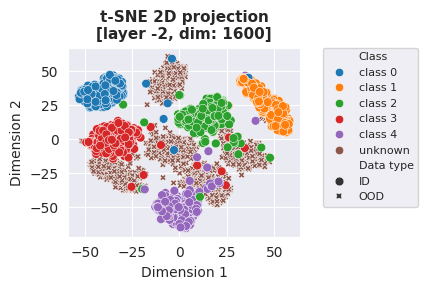

In [5]:
# penultimate features 2d visualization
print("\n=== Penultimate features viz ===")
plt.figure(figsize=(4.5, 3))
plot_2D_features(
    model=model,
    in_dataset=ds_in,
    out_dataset=ds_out,
    output_layer_id=-2,
)
plt.tight_layout()
plt.show()

### DKNN score

We now fit a DKNN detector with MNIST[0-4] train dataset, and compare OOD scores
returned for MNIST[0-4] (ID) and MNIST[5-9] (OOD) test datasets.


=== Metrics ===
auroc      0.956042
fpr95tpr   0.159175

=== Plots ===


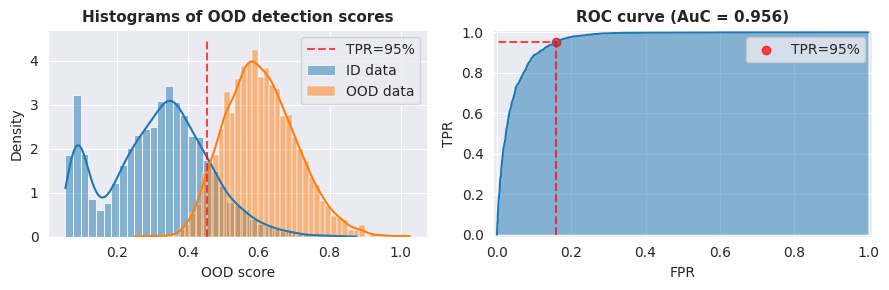

In [6]:
# === DKNN scores ===
dknn = DKNN(nearest=50)
dknn.fit(model, feature_layers_id=[-2], fit_dataset=ds_in)
scores_in, _ = dknn.score(ds_in)
scores_out, _ = dknn.score(ds_out)

# === metrics ===
# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
print("=== Metrics ===")
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")

print("\n=== Plots ===")
# hists / roc
plt.figure(figsize=(9, 3))
plt.subplot(121)
plot_ood_scores(scores_in, scores_out, log_scale=False)
plt.subplot(122)
plot_roc_curve(scores_in, scores_out)
plt.tight_layout()
plt.show()

In [ ]:
dknn.feature_extractor

### Mahalanobis score

We now fit a Mahalanobis OOD detector with MNIST[0-4] train dataset, and compare OOD
scores returned for MNIST[0-4] (ID) and MNIST[5-9] (OOD) test datasets.


=== Metrics ===
auroc      0.890643
fpr95tpr   0.431601

=== Plots ===


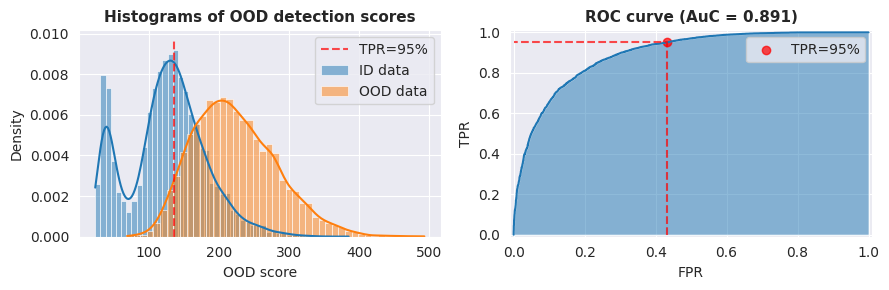

In [8]:
# === Mahalanobis scores ===
mahalanobis = Mahalanobis(eps=0.002)
mahalanobis.fit(model, feature_layers_id=[-2], fit_dataset=ds_fit)
scores_in, _ = mahalanobis.score(ds_in)
scores_out, _ = mahalanobis.score(ds_out)
clear_output()

# === metrics ===
# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
print("=== Metrics ===")
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")

print("\n=== Plots ===")
# hists / roc
plt.figure(figsize=(9, 3))
plt.subplot(121)
plot_ood_scores(scores_in, scores_out, log_scale=False)
plt.subplot(122)
plot_roc_curve(scores_in, scores_out)
plt.tight_layout()
plt.show()

### SHE score for MNIST0-4

REQUIRES TOY_MLP MODEL !!!

In [9]:
# # === SHE scores ===
# she = SHE()
# she.fit(model, ds_train, feature_layers_id=["dense", "dense_1"])  # toy_mlp model !!!

# scores_in, _ = she.score(ds_in)
# scores_out, _ = she.score(ds_out)

# # Since many scores are equal to 0, we add a random noise to avoid bugs
# # in Auroc and TPR computation.
# scores_in += np.random.random_sample(size=scores_in.shape) * 10e-6
# scores_out += np.random.random_sample(size=scores_out.shape) * 10e-6

# # === metrics ===
# # auroc / fpr95
# metrics = bench_metrics(
#     (scores_in, scores_out),
#     metrics=["auroc", "fpr95tpr"],
# )
# print("=== Metrics ===")
# for k, v in metrics.items():
#     print(f"{k:<10} {v:.6f}")

# print("\n=== Plots ===")
# # hists / roc
# plt.figure(figsize=(9, 3))
# plt.subplot(121)
# plot_ood_scores(scores_in, scores_out)
# plt.subplot(122)
# plot_roc_curve(scores_in, scores_out)
# plt.tight_layout()
# plt.show()

## Second experiment: CIFAR-10 vs SVHN

For this second experiment, we oppose **CIFAR-10** (in-distribution dataset) to **SVHN**
(out-of-distribution dataset).


### Data loading

- In-distribution data: CIFAR-10
- Out-of-distribution data: SVHN


In [10]:
# === Load ID and OOD data ===
batch_size = 128

data_handler = load_data_handler("tensorflow")

# 1a- Load in-distribution dataset: CIFAR-10
ds_fit = data_handler.load_dataset("cifar10", load_kwargs={"split": "train"})
ds_in = data_handler.load_dataset("cifar10", load_kwargs={"split": "test"})

# 1b- Load out-of-distribution dataset: SVHN
ds_out = data_handler.load_dataset("svhn_cropped", load_kwargs={"split": "test"})


# 2- prepare data (preprocess, shuffle, batch)
def preprocess_fn(inputs):
    inputs["image"] /= 255
    # inputs["label"] = keras.utils.to_categorical(inputs["label"], num_classes=10)
    return inputs


ds_fit = data_handler.prepare(
    ds_fit, batch_size, preprocess_fn, shuffle=True, columns=["image", "label"]
)
ds_in = data_handler.prepare(
    ds_in, batch_size, preprocess_fn, columns=["image", "label"]
)
ds_out = data_handler.prepare(
    ds_out, batch_size, preprocess_fn, columns=["image", "label"]
)

clear_output()

### Model loading

The model is a **ResNet** pretrained on CIFAR-10 and getting an accuracy score of
92.75%.


/home/corentin.friedrich/dev/oodeel/.venv_keras3/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
I0000 00:00:1744795210.020180 4187101 service.cc:152] XLA service 0x747ef0004400 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744795210.020199 4187101 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6


19/79 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3789 - sparse_categorical_accuracy: 0.9359

I0000 00:00:1744795212.823393 4187101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 0.3980 - sparse_categorical_accuracy: 0.9296
Test accuracy:	0.9274

=== Penultimate features viz ===


/home/corentin.friedrich/dev/oodeel/.venv_keras3/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


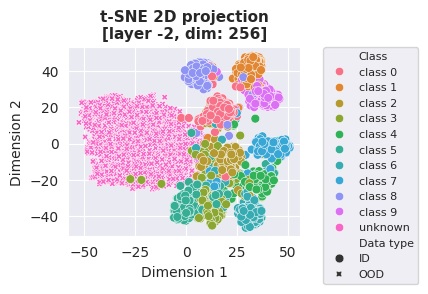

In [11]:
# === Load model ===
# ResNet pretrained on CIFAR-10
model_path_resnet_cifar10 = keras.utils.get_file(
    "cifar10_resnet256.h5",
    origin="https://share.deel.ai/s/kram9kLpx6JwRX4/download/cifar10_resnet256.h5",
    cache_dir=model_path,
    cache_subdir="",
)
model = keras.models.load_model(model_path_resnet_cifar10)

# Evaluate model
model.compile(
    loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"]
)
_, accuracy = model.evaluate(ds_in)
print(f"Test accuracy:\t{accuracy:.4f}")

# penultimate features 2d visualization
print("\n=== Penultimate features viz ===")
plt.figure(figsize=(4.5, 3))
plot_2D_features(
    model=model,
    in_dataset=ds_in,
    out_dataset=ds_out,
    output_layer_id=-2,
)
plt.tight_layout()
plt.show()

### DKNN score

We now fit a DKNN detector with CIFAR-10 train dataset, and compare OOD scores returned
for CIFAR-10 (ID) and SVHN (OOD) test datasets.


=== Metrics ===
auroc      0.993150
fpr95tpr   0.034200

=== Plots ===


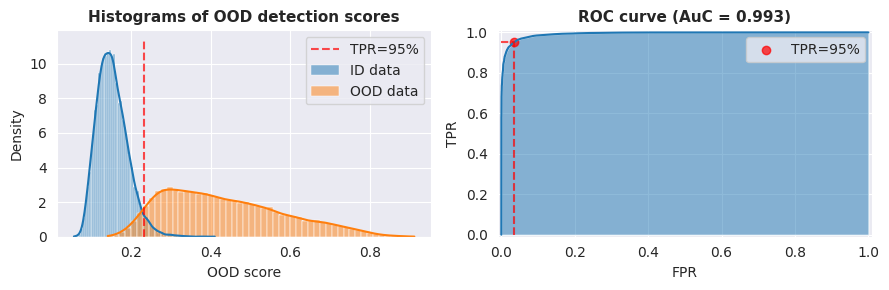

In [12]:
# === DKNN scores ===
dknn = DKNN(nearest=50)
dknn.fit(model, feature_layers_id=[-2], fit_dataset=ds_fit)
scores_in, _ = dknn.score(ds_in)
scores_out, _ = dknn.score(ds_out)

# === metrics ===
# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
print("=== Metrics ===")
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")

print("\n=== Plots ===")
# hists / roc
plt.figure(figsize=(9, 3))
plt.subplot(121)
plot_ood_scores(scores_in, scores_out, log_scale=False)
plt.subplot(122)
plot_roc_curve(scores_in, scores_out)
plt.tight_layout()
plt.show()

### Mahalanobis score for CIFAR-10

=== Metrics ===
auroc      0.717594
fpr95tpr   0.812300

=== Plots ===


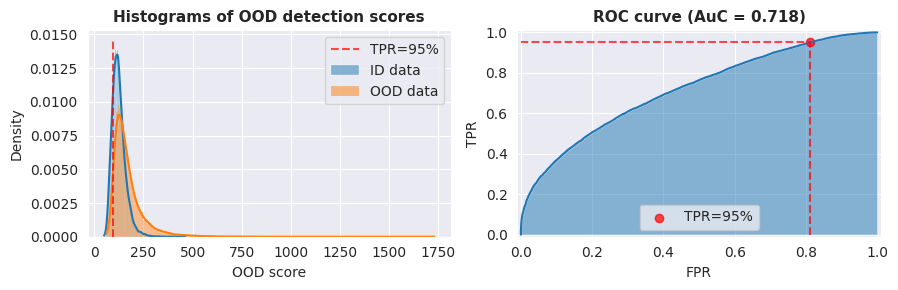

In [13]:
# === Mahalanobis OOD scores ===
mahalanobis = Mahalanobis(eps=-1)  # default eps=0.002
mahalanobis.fit(model, feature_layers_id=[-2], fit_dataset=ds_fit)
scores_in, _ = mahalanobis.score(ds_in)
scores_out, _ = mahalanobis.score(ds_out)

# === metrics ===
# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
print("=== Metrics ===")
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")

print("\n=== Plots ===")
# hists / roc
plt.figure(figsize=(9, 3))
plt.subplot(121)
plot_ood_scores(scores_in, scores_out, log_scale=False)
plt.subplot(122)
plot_roc_curve(scores_in, scores_out)
plt.tight_layout()
plt.show()

### SHE score for CIFAR-10

=== Metrics ===
auroc      0.988405
fpr95tpr   0.054500

=== Plots ===


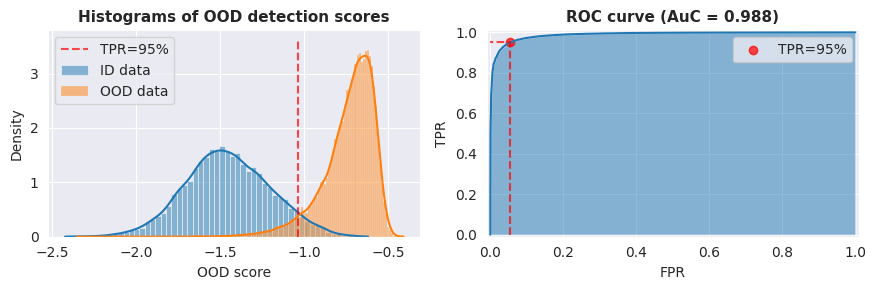

In [15]:
# === gram scores ===
she = SHE()
she.fit(
    model,
    ds_fit,
    feature_layers_id=[
        "conv2d_18",
        "activation_17",
        "conv2d_37",
        "activation_35",
        "conv2d_56",
        "activation_53",
        "flatten",
    ],
)

scores_in, _ = she.score(ds_in)
scores_out, _ = she.score(ds_out)

scores_in += np.random.random_sample(size=scores_in.shape) * 10e-6
scores_out += np.random.random_sample(size=scores_out.shape) * 10e-6

# === metrics ===
# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
print("=== Metrics ===")
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")


print("\n=== Plots ===")
# hists / roc
plt.figure(figsize=(9, 3))
plt.subplot(121)
plot_ood_scores(scores_in, scores_out)
plt.subplot(122)
plot_roc_curve(scores_in, scores_out)
plt.tight_layout()
plt.show()